In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from gurobipy import Model, GRB, quicksum

# --- Load Data ---
df_price = pd.read_excel("data/Price.xlsx")
df_price = df_price[df_price["PriceArea"]=="DK2"].drop(columns=["HourUTC"]).rename(columns={"HourDK":"Hour"}).reset_index(drop=True)
df_price.index = pd.to_datetime(df_price.Hour)
df_price = df_price.drop(columns=["Hour"])
df_price.index.name = "Timestamp"

# --- 80-20 train/test split ---
df_train = df_price.iloc[:int(round(0.8*len(df_price),0))].copy()
df_test  = df_price.iloc[int(round(0.8*len(df_price),0)):].copy()

**Model 1 LR**

In [3]:
# --- 1. Find Optimal Solution for Training Data (Labels) ---
Timeframe = len(df_train)
lam = df_train.PriceDKK.values
P_max = 100.0
E_max = 400.0

m = Model()
m.setParam('OutputFlag', 0) # Silence output

E = m.addVars(Timeframe, lb=0.0, ub=E_max, vtype=GRB.CONTINUOUS)
a_ch = m.addVars(Timeframe, vtype=GRB.BINARY)
a_di = m.addVars(Timeframe, vtype=GRB.BINARY)
a_id = m.addVars(Timeframe, vtype=GRB.BINARY)

m.setObjective(quicksum(lam[t] * P_max * (a_di[t] - a_ch[t]) for t in range(Timeframe)), GRB.MAXIMIZE)

for t in range(Timeframe - 1):
    m.addConstr(E[t+1] == E[t] + P_max * a_ch[t] - P_max * a_di[t])
for t in range(Timeframe):
    m.addConstr(E[t] <= E_max)
    m.addConstr(a_ch[t] + a_di[t] + a_id[t] == 1)
m.addConstr(E[0] == 0.0)
m.optimize()

# --- 2. Create Training Data (X, y) ---
X_train = []
y_train = []

for t in range(1, Timeframe):
    soc_t = E[t].X / E_max
    price_prev = lam[t-1]
    X_train.append([soc_t, price_prev])
    
    if a_ch[t].X >= 0.5: y_train.append(1)
    elif a_di[t].X >= 0.5: y_train.append(0)
    else: y_train.append(np.nan)

X_train = np.array(X_train)
y_train = np.array(y_train, dtype=float)
mask = ~np.isnan(y_train)
X_train = X_train[mask]
y_train = y_train[mask]

# --- 3. Train Classifier (GridSearch) ---
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty=None, max_iter=1000, solver="lbfgs")
)

tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}

grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring="accuracy", n_jobs=-1, refit=True)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

# --- 4. Simulation Function & Threshold Tuning ---
def simulate_with_classifier(clf, lam, P_hat, P_max, E_max, E0=0.0):
    if hasattr(lam, "values"): lam = lam.values
    else: lam = np.array(lam)

    T = len(lam)
    E = E0 
    profit = 0.0 
    profits = [0.0]           
    soc_history = [E0]        
    action_history = [0]      

    for t in range(1, T):
        soc_norm = E / E_max
        price_prev = lam[t-1]
        
        x_t = np.array([[soc_norm, price_prev]])
        p_charge = clf.predict_proba(x_t)[0, 1]

        # Action Logic
        if p_charge > P_hat: action_str = "charge"
        elif p_charge < 1.0 - P_hat: action_str = "discharge"
        else: action_str = "idle"

        if action_str == "charge" and E >= E_max: action_str = "idle"
        if action_str == "discharge" and E <= 0: action_str = "idle"

        price = lam[t]
        hourly_profit = 0.0
        action_val = 0

        if action_str == "charge":
            dE = min(P_max, E_max - E)
            E += dE
            hourly_profit = -1 * price * dE
            action_val = 1
        elif action_str == "discharge":
            dE = min(P_max, E)
            E -= dE
            hourly_profit = price * dE
            action_val = -1
        
        profit += hourly_profit
        profits.append(hourly_profit)
        soc_history.append(E)
        action_history.append(action_val)

    return profit, profits, soc_history, action_history

# Tune P_hat
P_candidates = np.linspace(0.2, 0.6, 20)
lam_train_vals = X_train[:, 1]
cv_scores = {P_hat: [] for P_hat in P_candidates}

for fold, (train_idx, val_idx) in enumerate(tscv.split(lam_train_vals)):
    lam_val = lam_train_vals[val_idx]
    for P_hat in P_candidates:
        profit, _, _, _ = simulate_with_classifier(clf, lam_val, P_hat, P_max, E_max)
        cv_scores[P_hat].append(profit)

avg_profit = {P_hat: np.mean(scores) for P_hat, scores in cv_scores.items()}
best_P = max(avg_profit, key=avg_profit.get)
print("LR Model Trained. Best P_hat:", best_P)

Set parameter Username
Set parameter LicenseID to value 2740741
Academic license - for non-commercial use only - expires 2026-11-18
LR Model Trained. Best P_hat: 0.368421052631579


In [4]:
Timeframe = len(df_test)        
lam = df_test.PriceDKK  
# Note: P_max/E_max already defined above

m_test = Model()
m_test.setParam('OutputFlag', 0)

E_opt_var = m_test.addVars(Timeframe, lb=0.0, ub=E_max, vtype=GRB.CONTINUOUS)
a_ch_opt = m_test.addVars(Timeframe, vtype=GRB.BINARY)
a_di_opt = m_test.addVars(Timeframe, vtype=GRB.BINARY)
a_id_opt = m_test.addVars(Timeframe, vtype=GRB.BINARY)

m_test.setObjective(quicksum(lam[t] * P_max * (a_di_opt[t] - a_ch_opt[t]) for t in range(Timeframe)), GRB.MAXIMIZE)

for t in range(Timeframe - 1):
    m_test.addConstr(E_opt_var[t+1] == E_opt_var[t] + P_max * a_ch_opt[t] - P_max * a_di_opt[t])
for t in range(Timeframe):
    m_test.addConstr(E_opt_var[t] <= E_max)
    m_test.addConstr(a_ch_opt[t] + a_di_opt[t] + a_id_opt[t] == 1)
m_test.addConstr(E_opt_var[0] == 0.0)
m_test.optimize()
print("Optimal Benchmark Calculated.")

/var/folders/q8/hp5tdz793z58hj74f9nv4q9r0000gn/T/ipykernel_27484/3996990953.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m_test.setObjective(quicksum(lam[t] * P_max * (a_di_opt[t] - a_ch_opt[t]) for t in range(Timeframe)), GRB.MAXIMIZE)


Optimal Benchmark Calculated.


**Model 2: RL**

In [5]:
# --- 1. RL Setup & Discretization ---
num_bins = 14
train_prices = df_train["PriceDKK"].values
test_prices  = df_test["PriceDKK"].values

bin_edges = np.quantile(train_prices, np.linspace(0, 1, num_bins + 1))
bin_edges[0] -= 1e-6 

df_train["price_bin"] = np.clip(np.digitize(train_prices, bin_edges), 1, num_bins)
df_test["price_bin"]  = np.clip(np.digitize(test_prices,  bin_edges), 1, num_bins)

# Price Transition Matrix
P_price = np.zeros((num_bins, num_bins))
bins_train = df_train["price_bin"].values
for t in range(1, len(bins_train)):
    P_price[bins_train[t-1]-1, bins_train[t]-1] += 1
row_sums = P_price.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  
P_price = P_price / row_sums

lambda_bar = np.zeros(num_bins)
for k in range(num_bins):
    members = train_prices[df_train["price_bin"] == (k + 1)]
    lambda_bar[k] = members.mean() if len(members) > 0 else 0.0

SOC_levels = np.arange(5)        
actions = np.array([-1, 0, 1])   

# --- 2. Build States, Transitions, Rewards ---
states = []
state_to_idx = {}
num_price_states = num_bins

for i in range(len(SOC_levels)):
    for k_prev in range(num_price_states):
        s_idx = len(states)
        states.append((i, k_prev))
        state_to_idx[(i, k_prev)] = s_idx

num_states = len(states)
num_actions = len(actions)
max_soc_index = SOC_levels[-1]

# Helpers
def feasible_actions_for_soc(i, actions, max_soc_index):
    feas = []
    for a in actions:
        if i == 0 and a == -1: continue
        if i == max_soc_index and a == 1: continue
        feas.append(a)
    return feas

feasible_actions = [feasible_actions_for_soc(s[0], actions, max_soc_index) for s in states]

P = np.zeros((num_states, num_actions, num_states))
R = np.zeros((num_states, num_actions))

for s_idx, (i, k_prev) in enumerate(states):
    expected_price = np.dot(P_price[k_prev, :], lambda_bar)
    for a_idx, a in enumerate(actions):
        if a not in feasible_actions[s_idx]: continue
        
        # Reward
        R[s_idx, a_idx] = expected_price * P_max * (-a)
        
        # Transition
        i_next = i + a
        if i_next < 0 or i_next > max_soc_index: continue
        
        for k_next in range(num_price_states):
            prob = P_price[k_prev, k_next]
            if prob > 0:
                s_next = state_to_idx[(i_next, k_next)]
                P[s_idx, a_idx, s_next] += prob

# --- 3. Value Iteration ---
gamma = 0.99
V = np.zeros(num_states)
for it in range(10000):
    V_old = V.copy()
    for s_idx in range(num_states):
        q_values = []
        for a_idx, a in enumerate(actions):
            if a not in feasible_actions[s_idx]: continue
            q_sa = R[s_idx, a_idx] + gamma * np.dot(P[s_idx, a_idx, :], V_old)
            q_values.append(q_sa)
        V[s_idx] = max(q_values) if q_values else 0.0
    if np.max(np.abs(V - V_old)) < 1e-6: break

# --- 4. Extract Policy ---
policy_idx = np.zeros(num_states, dtype=int)
for s_idx in range(num_states):
    best_q = -np.inf
    best_a_idx = 0 
    for a_idx, a in enumerate(actions):
        if a not in feasible_actions[s_idx]: continue
        q_sa = R[s_idx, a_idx] + gamma * np.dot(P[s_idx, a_idx, :], V)
        if q_sa > best_q:
            best_q = q_sa
            best_a_idx = a_idx
    policy_idx[s_idx] = best_a_idx

policy_actions = actions[policy_idx]
print("RL Training Complete.")

RL Training Complete.


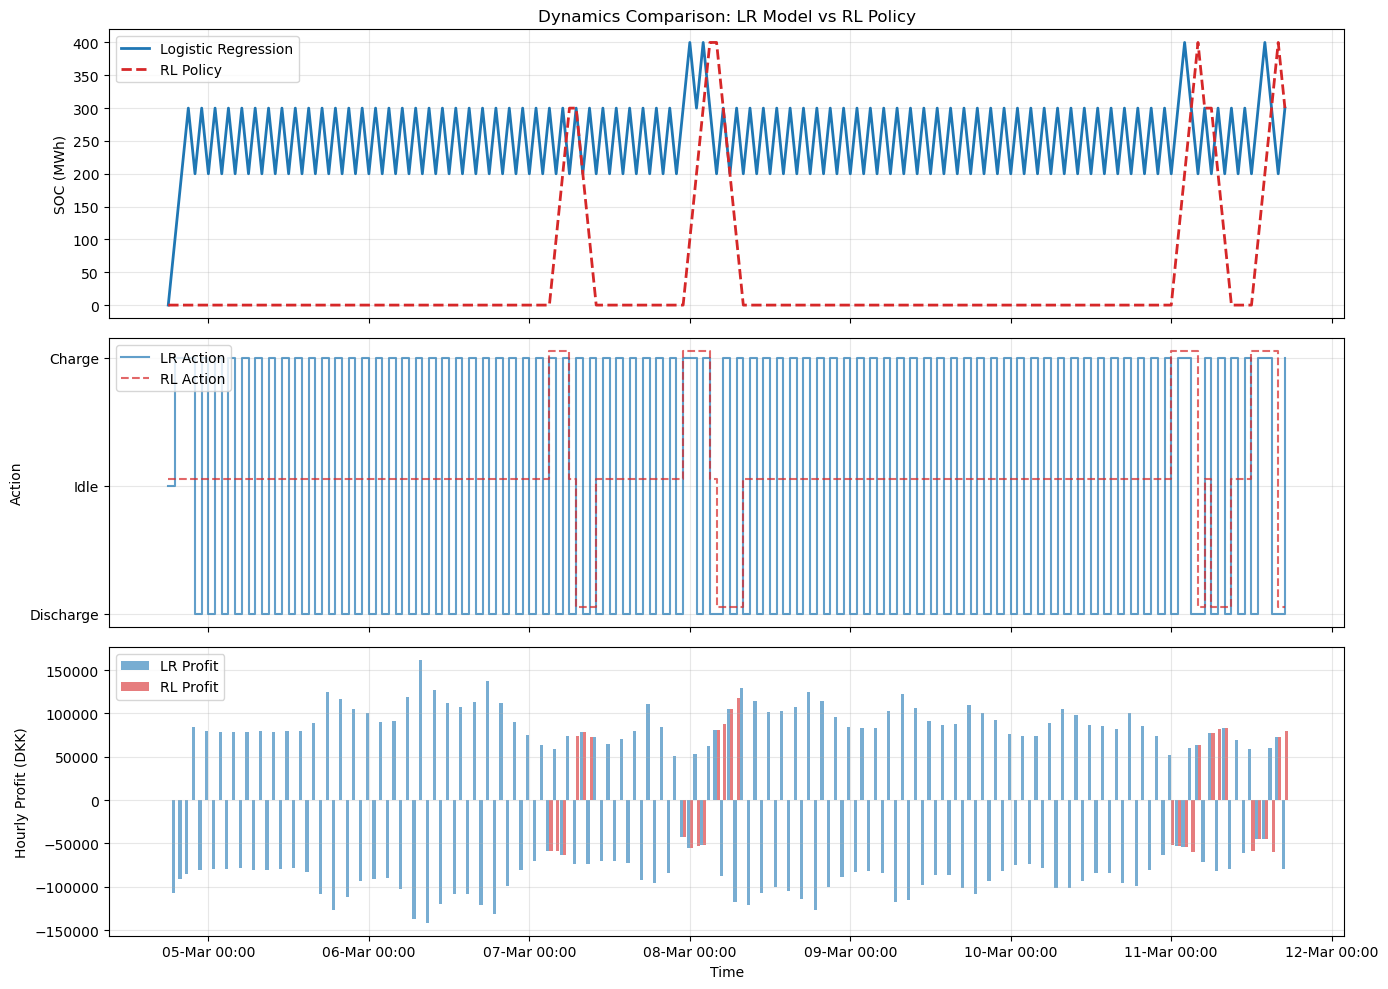

Optimal Total: 56.232235 MDKK
LR Capture:    10.22%
LR Capture:    5.747222MDKK
RL Capture:    45.58%
RL Capture:    25.628184MDKK


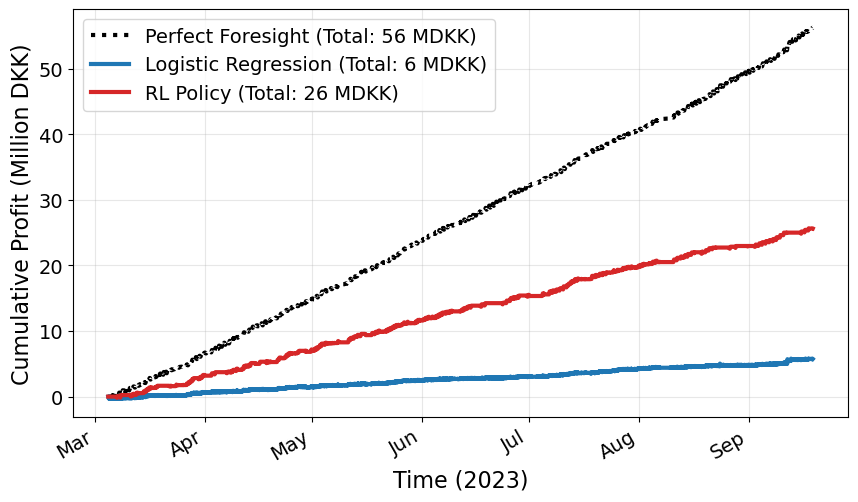

In [6]:
# --- 1. Run Simulations on Test Set ---

# A. Logistic Regression
lam_values = df_test["PriceDKK"].values
profit_lr_total, profits_lr, soc_lr, action_lr = simulate_with_classifier(
    clf, lam_values, best_P, P_max, E_max
)

# B. RL Policy
soc_idx = 0 
prev_price_bin_idx = df_test["price_bin"].iloc[0] - 1
profits_rl = []
soc_history_rl = []
action_history_rl = []

for t in range(len(df_test)):
    price = df_test["PriceDKK"].iloc[t]
    price_bin_idx = df_test["price_bin"].iloc[t] - 1
    
    s_idx = state_to_idx[(soc_idx, prev_price_bin_idx)]
    action = policy_actions[s_idx] 

    if soc_idx == 0 and action == -1: action = 0
    if soc_idx == max_soc_index and action == 1: action = 0

    profit_t = price * P_max * (-action) 
    profits_rl.append(profit_t)
    soc_history_rl.append(soc_idx)
    action_history_rl.append(action)

    soc_idx = max(0, min(max_soc_index, soc_idx + action))
    prev_price_bin_idx = price_bin_idx

# C. Optimal (Recovered from Gurobi variables)
profits_opt = []
soc_opt = []
for t in range(len(df_test)):
    charge_opt = a_ch_opt[t].X
    discharge_opt = a_di_opt[t].X
    soc_val = E_opt_var[t].X
    p_opt = df_test["PriceDKK"].iloc[t] * P_max * (discharge_opt - charge_opt)
    profits_opt.append(p_opt)
    soc_opt.append(soc_val)

# --- 2. Consolidate Data ---
df_compare = df_test.copy()
df_compare["SOC_LR"] = soc_lr
df_compare["Action_LR"] = action_lr
df_compare["Profit_LR"] = profits_lr
df_compare["SOC_RL"] = np.array(soc_history_rl) * 100 
df_compare["Action_RL"] = action_history_rl
df_compare["Profit_RL"] = profits_rl
df_compare["SOC_Opt"] = soc_opt
df_compare["Profit_Opt"] = profits_opt
if "Timestamp" not in df_compare.columns:
    df_compare = df_compare.reset_index().rename(columns={"index": "Timestamp"})

# --- 3. Plot 1: Dynamics (First Week) ---
subset = df_compare.iloc[:168].copy()
time = subset["Timestamp"]
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(time, subset["SOC_LR"], color="tab:blue", label="Logistic Regression", linewidth=2)
axes[0].plot(time, subset["SOC_RL"], color="tab:red", label="RL Policy", linestyle="--", linewidth=2)
axes[0].set_ylabel("SOC (MWh)")
axes[0].set_title("Dynamics Comparison: LR Model vs RL Policy")
axes[0].legend(loc="upper left")
axes[0].grid(True, alpha=0.3)

axes[1].step(time, subset["Action_LR"], where="post", color="tab:blue", label="LR Action", alpha=0.7)
axes[1].step(time, subset["Action_RL"] + 0.05, where="post", color="tab:red", label="RL Action", linestyle="--", alpha=0.7)
axes[1].set_ylabel("Action")
axes[1].set_yticks([-1, 0, 1])
axes[1].set_yticklabels(["Discharge", "Idle", "Charge"])
axes[1].legend(loc="upper left")
axes[1].grid(True, alpha=0.3)

width = 0.02 
time_nums = mdates.date2num(time)
axes[2].bar(time_nums - width/2, subset["Profit_LR"], width=width, color="tab:blue", label="LR Profit", alpha=0.6)
axes[2].bar(time_nums + width/2, subset["Profit_RL"], width=width, color="tab:red", label="RL Profit", alpha=0.6)
axes[2].set_ylabel("Hourly Profit (DKK)")
axes[2].legend(loc="upper left")
axes[2].grid(True, alpha=0.3)
axes[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%d-%b %H:%M"))
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# --- 4. Plot 2: Cumulative Profit ---
cum_lr = np.cumsum(df_compare["Profit_LR"])/1e6
cum_rl = np.cumsum(df_compare["Profit_RL"])/1e6
cum_opt = np.cumsum(df_compare["Profit_Opt"])/1e6

plt.figure(figsize=(10, 6))
plt.plot(df_compare["Timestamp"], cum_opt, color="black", linestyle=":", label=f"Perfect Foresight (Total: {cum_opt.iloc[-1]:.0f} MDKK)", linewidth=3)
plt.plot(df_compare["Timestamp"], cum_lr, color="tab:blue", label=f"Logistic Regression (Total: {cum_lr.iloc[-1]:.0f} MDKK)", linewidth=3)
plt.plot(df_compare["Timestamp"], cum_rl, color="tab:red", label=f"RL Policy (Total: {cum_rl.iloc[-1]:.0f} MDKK)", linewidth=3)

plt.ylabel("Cumulative Profit (Million DKK)", fontsize=16)
plt.xlabel("Time (2023)", fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gcf().autofmt_xdate()

opt_total = cum_opt.iloc[-1]
print(f"Optimal Total: {opt_total:,.6f} MDKK")
print(f"LR Capture:    {cum_lr.iloc[-1] / opt_total * 100:.2f}%")
print(f"LR Capture:    {cum_lr.iloc[-1]:.6f}MDKK")
print(f"RL Capture:    {cum_rl.iloc[-1] / opt_total * 100:.2f}%")
print(f"RL Capture:    {cum_rl.iloc[-1]:.6f}MDKK")
plt.show()